In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import artm
import numpy as np
from matplotlib.artist import getp
import pandas as pd
import datetime

In [2]:
df = pd.read_csv('./data/preprocessed/df_textrank_clean_replace_more_13.csv')

/home/anisimova-anna/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
name = 'clean_replace_ent_text_textrank_more_13'
batch_folder = './{}_batches'.format(name)
data_path = './{}_vw.txt'.format(name)
dict_path = batch_folder + '/dictionary.dict'  

dic = artm.Dictionary()

if os.path.isfile(dict_path):
    dic.load(dictionary_path=dict_path)

    batch_vectorizer = artm.BatchVectorizer(data_path=data_path, 
                                    data_format='vowpal_wabbit', 
                                    collection_name='nthhappens', 
                                    target_folder=batch_folder)

In [4]:
n = 30
topic_names = ['topic_{}'.format(i) for i in range(n)]

#* num_document_passes 1 2 5
#* probability_mass_threshold 0.01 0.1 0.5
* DecorrelatorPhiRegularizer 10^6 10^7 10^8 10^9         10^6 10^8
* SmoothSparseThetaRegularizer -0.1 -0.2 -0.5 -1 -1.5 -2         -0.1 -0.5 -1
* SmoothSparsePhiRegularizer -0.1 -0.05 0.05 0.1 0.25 0.5 0.75        -0.1  0.1  0.75

In [5]:
def train_1_decorr(params=[1.e+5, 1.e+6, 1.e+7, 1.e+8], pmt=0.3, num_document_passes=2, num_collection_passes=8):
    models = []
    for param in params:
        # initialization
        model = artm.ARTM(topic_names=topic_names, cache_theta=True,
                           class_ids={'@default_class': 1.0, '@ents': 3.0, '@textrank': 1.5},
                           scores=[artm.PerplexityScore(name='PerplexityScore',
                                                        dictionary=dic)],
                         regularizers=[artm.SmoothSparseThetaRegularizer(
                             name='SparseTheta', tau=-0.2)])    
        # scores
        model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
        model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
        model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', topic_names=topic_names,dictionary=dic,
                                                      probability_mass_threshold=pmt, class_id='@default_class'))
        model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10, 
                                             class_id='@default_class', dictionary=dic))
        #regularizers
        model.regularizers.add(artm.SmoothSparsePhiRegularizer(
                            name='SparsePhi', tau=-0.1, class_ids='@default_class'))
        model.regularizers.add(artm.DecorrelatorPhiRegularizer(
                            name='DecorrelatorPhi', tau=param, class_ids='@default_class'))

        # dictionary
        model.num_document_passes = num_document_passes
        model.initialize(dictionary=dic)

        #fit 1
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_collection_passes)
        print('model fitted', ' ', datetime.datetime.now().time())
        models.append(model)
    return models

In [6]:
def train_2_sparse_theta(best_1, params=[-0.1, -0.2, -0.5, -1, -1.5, -2], pmt=0.3, num_document_passes=2, num_collection_passes=8):
    models = []
    for param in params:
        # fit 1
        mod_1 = train_1_decorr([best_1])[0]
        
        #tuning
        mod_1.regularizers['SparseTheta'].tau = param
        
        #fit 1
        mod_1.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_collection_passes)
        print('model fitted', ' ', datetime.datetime.now().time())
        models.append(mod_1)
    return models

In [7]:
def train_3_sparse_phi(best_1, best_2, params=[-0.1, -0.05, 0.05, 0.1, 0.25, 0.5, 0.75], pmt=0.3, num_document_passes=2, num_collection_passes=8):
    models = []
    for param in params:
        # fit 1
        mod_2 = train_2_sparse_theta(best_1=best_1, params=[best_2])[0]
        
        #tuning
        mod_2.regularizers['SparsePhi'].tau = param
        
        #fit 1
        mod_2.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_collection_passes)
        print('model fitted', ' ', datetime.datetime.now().time())
        models.append(mod_2)
    return models

In [10]:
ms_1 = train_1_decorr()

model fitted   03:00:56.422641
model fitted   03:02:06.581778
model fitted   03:03:17.944282
model fitted   03:04:30.037283


In [11]:
names1 = ['mod_1_tau_{}'.format(tau) for tau in [1.e+5, 1.e+6, 1.e+7, 1.e+8]]

In [14]:
for_df = []
for mod in ms_1:
    for_df.append(
        {'Perplexity': mod.score_tracker['PerplexityScore'].value, 
         'SparsityPhi': mod.score_tracker['SparsityPhiScore'].value, 
         'SparsityTheta': mod.score_tracker['SparsityThetaScore'].value, 
         'Kernel_purity': mod.score_tracker['TopicKernelScore'].average_purity, 
         'Kernel_size': mod.score_tracker['TopicKernelScore'].average_size, 
         'Kernel_conrtast': mod.score_tracker['TopicKernelScore'].average_contrast,
        'last_perplexity': mod.score_tracker['PerplexityScore'].last_value}
    )

In [22]:
resdf = pd.DataFrame(for_df, index=names1)
resdf.to_csv('./tuning_results.csv', index=None)

In [8]:
resdf = pd.read_csv('./tuning_results.csv')

In [14]:
resdf.index = names1

In [16]:
best_1 = float(resdf.sort_values('last_perplexity').index[0].split('_')[-1])

In [35]:
ms_2 = train_2_sparse_theta(best_1)

model fitted   03:20:46.451992
model fitted   03:22:21.775490
model fitted   03:23:58.843066
model fitted   03:25:34.005970
model fitted   03:27:12.815841
model fitted   03:28:49.803179
model fitted   03:30:35.787513
model fitted   03:32:21.465898
model fitted   03:34:05.969783
model fitted   03:35:49.059143
model fitted   03:37:35.432451
model fitted   03:39:19.695632


In [18]:
names2 = ['mod_2_tau_{}'.format(tau) for tau in [-0.1, -0.2, -0.5, -1, -1.5, -2]]

In [37]:
for_df2 = []
for mod in ms_2:
    for_df.append(
        {'Perplexity': mod.score_tracker['PerplexityScore'].value, 
         'SparsityPhi': mod.score_tracker['SparsityPhiScore'].value, 
         'SparsityTheta': mod.score_tracker['SparsityThetaScore'].value, 
         'Kernel_purity': mod.score_tracker['TopicKernelScore'].average_purity, 
         'Kernel_size': mod.score_tracker['TopicKernelScore'].average_size, 
         'Kernel_conrtast': mod.score_tracker['TopicKernelScore'].average_contrast,
        'last_perplexity': mod.score_tracker['PerplexityScore'].last_value}
    )

In [38]:
resdf2 = pd.DataFrame(for_df + for_df2, index=names1+names2)
resdf2.to_csv('./tuning_results2.csv', index=None)

In [17]:
resdf2 = pd.read_csv('./tuning_results2.csv')

In [20]:
resdf2.index = names1+names2

In [21]:
best_2 = float(resdf2.sort_values('last_perplexity').index[0].split('_')[-1])

In [22]:
ms_3 = train_3_sparse_phi(best_1, best_2)

model fitted   03:51:27.121351
model fitted   03:52:58.334086
model fitted   03:54:25.792855
model fitted   03:55:54.259034
model fitted   03:57:20.996944
model fitted   03:58:48.193834
model fitted   04:00:17.887255
model fitted   04:01:45.800850
model fitted   04:03:15.430611
model fitted   04:04:48.804937
model fitted   04:06:18.405687
model fitted   04:07:49.048060
model fitted   04:09:20.947008
model fitted   04:10:51.718006
model fitted   04:12:23.016120
model fitted   04:13:57.542204
model fitted   04:15:29.742235
model fitted   04:17:02.888782
model fitted   04:18:39.207622
model fitted   04:20:13.839763
model fitted   04:21:48.371365


In [27]:
names3 = ['mod_3_tau_{}'.format(tau) for tau in [-0.1, -0.05, 0.05, 0.1, 0.25, 0.5, 0.75]]

for_df3 = []
for mod in ms_3:
    for_df3.append(
        {'Perplexity': mod.score_tracker['PerplexityScore'].value, 
         'SparsityPhi': mod.score_tracker['SparsityPhiScore'].value, 
         'SparsityTheta': mod.score_tracker['SparsityThetaScore'].value, 
         'Kernel_purity': mod.score_tracker['TopicKernelScore'].average_purity, 
         'Kernel_size': mod.score_tracker['TopicKernelScore'].average_size, 
         'Kernel_conrtast': mod.score_tracker['TopicKernelScore'].average_contrast,
        'last_perplexity': mod.score_tracker['PerplexityScore'].last_value}
    )

In [26]:
resdf_3 = pd.DataFrame(for_df3, index=names3)
resdf_3.to_csv('./tuning_results_3.csv')

In [30]:
final = ms_3[0]

In [33]:
resdf2

,Kernel_conrtast,Kernel_purity,Kernel_size,Perplexity,SparsityPhi,SparsityTheta,last_perplexity
mod_1_tau_100000.0,"[0.6261535882949829, 0.5782241821289062, 0.600...","[0.0001923090749187395, 0.006467876955866814, ...","[982.0999755859375, 1533.699951171875, 2017.06...","[41180.27734375, 2482.07666015625, 2399.739257...","[0.7813102602958679, 0.8121960163116455, 0.835...","[8.375149263883941e-06, 9.284451516577974e-05,...",1895.993408
mod_1_tau_1000000.0,"[0.6114854216575623, 0.5715070962905884, 0.596...","[0.0001943232782650739, 0.006911489646881819, ...","[974.4666748046875, 1513.699951171875, 1989.53...","[41180.27734375, 2481.591552734375, 2366.08935...","[0.7820192575454712, 0.8126373887062073, 0.836...","[8.375149263883941e-06, 9.284451516577974e-05,...",1875.164429
mod_1_tau_10000000.0,"[0.512420654296875, 0.5346997976303101, 0.5769...","[0.00021307253336999565, 0.011058707721531391,...","[1012.8666381835938, 1399.7332763671875, 1822....","[41180.27734375, 2480.401611328125, 2311.15600...","[0.7885479927062988, 0.8176456093788147, 0.840...","[8.375149263883941e-06, 8.99730293895118e-05, ...",1532.697388
mod_1_tau_100000000.0,"[0.5231865048408508, 0.546846330165863, 0.5730...","[0.00011738424655050039, 0.024824704974889755,...","[518.6666870117188, 627.9000244140625, 1196.16...","[41180.27734375, 2467.708740234375, 2035.18774...","[0.8297589421272278, 0.8584244251251221, 0.955...","[8.375149263883941e-06, 8.781941869528964e-05,...",1767.611450
mod_2_tau_-0.1,"[0.5124205946922302, 0.5346997976303101, 0.576...","[0.0002130725042661652, 0.011058707721531391, ...","[1012.8666381835938, 1399.7332763671875, 1822....","[41180.27734375, 2480.401611328125, 2311.15600...","[0.7885479927062988, 0.8176456093788147, 0.840...","[8.375149263883941e-06, 8.99730293895118e-05, ...",1220.467529
mod_2_tau_-0.2,"[0.5124207139015198, 0.5346998572349548, 0.576...","[0.00021307253336999565, 0.011058707721531391,...","[1012.8666381835938, 1399.7332763671875, 1822....","[41180.27734375, 2480.401611328125, 2311.15600...","[0.7885479927062988, 0.8176456093788147, 0.840...","[8.375149263883941e-06, 8.99730293895118e-05, ...",1211.515625
mod_2_tau_-0.5,"[0.5124205946922302, 0.5346997976303101, 0.576...","[0.00021307253336999565, 0.011058707721531391,...","[1012.8666381835938, 1399.7332763671875, 1822....","[41180.27734375, 2480.401611328125, 2311.15600...","[0.7885479927062988, 0.8176456093788147, 0.840...","[8.375149263883941e-06, 8.99730293895118e-05, ...",1203.570190
mod_2_tau_-1,"[0.5124205946922302, 0.5346998572349548, 0.576...","[0.00021307253336999565, 0.011058707721531391,...","[1012.8666381835938, 1399.7332763671875, 1822....","[41180.27734375, 2480.401611328125, 2311.15600...","[0.7885479927062988, 0.8176456093788147, 0.840...","[8.375149263883941e-06, 8.99730293895118e-05, ...",1225.867920
mod_2_tau_-1.5,"[0.5124205946922302, 0.5346998572349548, 0.576...","[0.00021307253336999565, 0.011058708652853966,...","[1012.8666381835938, 1399.7332763671875, 1822....","[41180.27734375, 2480.401611328125, 2311.15600...","[0.7885479927062988, 0.8176456093788147, 0.840...","[8.375149263883941e-06, 8.99730293895118e-05, ...",1254.382202
mod_2_tau_-2,"[0.512420654296875, 0.5346997976303101, 0.5769...","[0.00021307253336999565, 0.011058707721531391,...","[1012.8666381835938, 1399.7332763671875, 1822....","[41180.27734375, 2480.401611328125, 2311.15600...","[0.7885479927062988, 0.8176456093788147, 0.840...","[8.375149263883941e-06, 8.99730293895118e-05, ...",1295.831909


In [63]:
def param_plot(plot_name, values, names, xs, iter_cnt, step=10):
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(1,1,1) 
    colors = ['r', 'b', 'g', 'y', 'k', 'o', 'r', 'b', 'g','r', 'b', 'g'][:len(names)]
    markers = ['o', '*', '<', 'o', '*', '<', 'o', '*', '<','o', '*', '<', 'o', ][:len(names)]

    for name, val, c, mark, x in zip(names, values, colors, markers, xs):
        plt.plot(x, val, c, linestyle='-', marker=mark, label=name)

    plt.legend(fontsize=14)
    plt.xlabel('Iteration number', fontsize=20)
    plt.ylabel(plot_name, fontsize=20)

    xticklabels = getp(plt.gca(), 'xticklabels')
    yticklabels = getp(plt.gca(), 'yticklabels')

    plt.setp(xticklabels, fontsize='large')
    plt.setp(yticklabels, fontsize='large')

    major_ticks_x = np.arange(xs[0][0] - 2, iter_cnt - 1, 1)                                              
    minor_ticks_x = np.arange(xs[0][0] - 2, iter_cnt - 1, 0.1)  
    major_ticks_y = np.arange((min(values[0])) // 100 * 100  - step * 2, max(values[0]) + step * 2,  step * 2)                                              
    minor_ticks_y = np.arange((min(values[0])) // 100 * 100  - step * 2, max(values[0]) +  step * 2, step)                                               

    ax.set_xticks(major_ticks_x)                                                       
    ax.set_xticks(minor_ticks_x, minor=True)   
    ax.set_yticks(major_ticks_y)                                                       
    ax.set_yticks(minor_ticks_y, minor=True) 

    ax.grid(which='both')                                                            

    ax.grid(which='minor', alpha=0.5)                                                
    ax.grid(which='major', alpha=1.0)
    

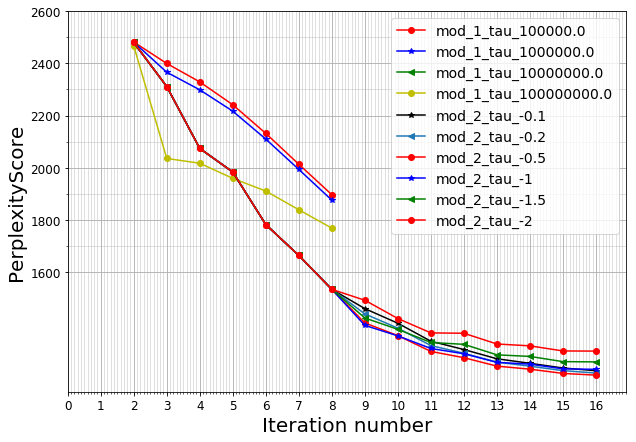

In [64]:
param_plot('PerplexityScore', 
           resdf2['Perplexity'].apply(eval).apply(lambda x: x[1:]).values, 
           resdf2.index,
           [list(range(2,9)) for i in range(4)] + [list(range(2,17)) for i in range(6)], 
           iter_cnt=18, step=100)

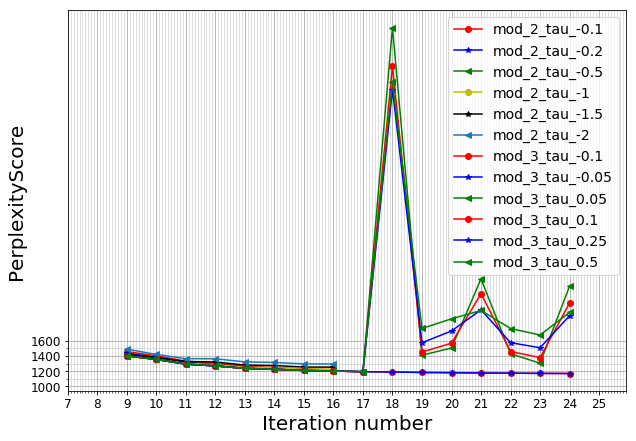

In [65]:
param_plot('PerplexityScore', 
           list(resdf2['Perplexity'].apply(eval).apply(lambda x: x[8:]).values[4:])\
                               + list(resdf_3['Perplexity'].apply(lambda x: x[8:]).values), 
           list(resdf2.index.values[4:]) + list(resdf_3.index),
           [list(range(9,17)) for i in range(6)] + [list(range(9,25)) for i in range(7)], 
           iter_cnt=27, step=100)

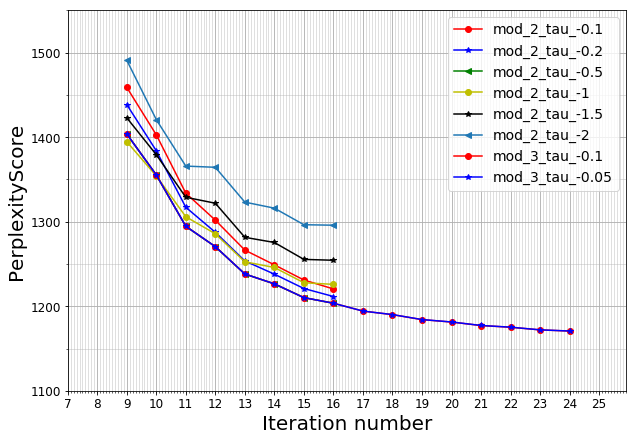

In [66]:
param_plot('PerplexityScore', 
           list(resdf2['Perplexity'].apply(eval).apply(lambda x: x[8:]).values[4:])\
                               + list(resdf_3['Perplexity'].apply(lambda x: x[8:]).values)[:2], 
           list(resdf2.index.values[4:]) + list(resdf_3.index)[:2],
           [list(range(9,17)) for i in range(6)] + [list(range(9,25)) for i in range(7)], 
           iter_cnt=27, step=50)

In [83]:
fin = final
qwe = []
for topic_name in fin.topic_names:
    qwe.append({'topic_tuned': topic_name, 'top_tuned': fin.score_tracker['TopTokensScore'].last_tokens[topic_name]})

pd.options.display.max_colwidth = 3000

pd.DataFrame(qwe).iloc[16:]

,top_tuned,topic_tuned
16,"[city, bitcoin, places, employees, startup, living, family, housing, global, women]",topic_16
17,"[app, believe, law, facebook, apps, features, amazon, computer, server, website]",topic_17
18,"[friends, opinion, comments, random, points, school, fun, guy, personally, dont_need]",topic_18
19,"[rate, million, class, fix, pretty_much, many_people, lower, chance, population, total]",topic_19
20,"[process, content, via, related, share, database, mentioned, note, main, open_source]",topic_20
21,"[development, online, device, javascript, api, browser, default, password, client, files]",topic_21
22,"[ads, legal, offer, interested, allowed, force, rights, doubt, plenty, ad]",topic_22
23,"[country, behavior, despite, prevent, logic, exists, arguments, black, false, structure]",topic_23
24,"[ai, original, field, happy, together, management, definition, hear, heard, wrote]",topic_24
25,"[discussion, youve, known, highly, hes, follow, particularly, recent, statement, suspect]",topic_25


In [67]:
fin = final
for topic_name in fin.topic_names:
    print(topic_name + ': ', fin.score_tracker['TopTokensScore'].last_tokens[topic_name])
    print()

topic_0:  ['application', 'tool', 'developer', 'scale', 'engineers', 'core', 'infrastructure', 'applications', 'os', 'switch']

topic_1:  ['help', 'platform', 'specifically', 'engineering', 'businesses', 'goal', 'customer', 'asking', 'engineer', 'include']

topic_2:  ['hours', 'goes', 'amount', 'per', 'average', 'higher', 'cars', 'house', 'months', 'office']

topic_3:  ['literally', 'assume', 'cause', 'search', 'ok', 'hit', 'safe', 'gives', 'potential', 'watch']

topic_4:  ['called', 'focus', 'fast', 'water', 'minutes', 'easier', 'age', 'room', 'week', 'children']

topic_5:  ['choose', 'popular', 'production', 'send', 'lets', 'couldnt', 'response', 'impact', 'continue', 'domain']

topic_6:  ['laws', 'products', 'countries', 'apply', 'remote', 'states', 'regulation', 'benefits', 'uk', 'individuals']

topic_7:  ['wonder', 'limited', 'meant', 'fully', 'somewhere', 'prefer', 'fit', 'added', 'teams', 'weve']

topic_8:  ['written', 'second', 'context', 'text', 'except', 'shouldnt', 'c_plus_p

In [70]:
def get_examples(model_artm, theta_matrix, df, topic_num, top=5):
    
    topic_name = 'topic_{}'.format(topic_num)
    print(topic_name)
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])
    
    topic_index = theta_matrix.T.sort_values(topic_name, ascending=False)[[topic_name]].iloc[:top].index
    print('\n')
    print('Texts:')
    for t in df.loc[topic_index]['text'].values:
        print(t)
        print('\n')

In [71]:
get_examples(final, final.get_theta(), df, 26)

topic_26
['program', 'linux', 'option', 'java', 'behind', 'block', 'types', 'instance', 'parts', 'library']


Texts:
> Having libraries implemented purely in the language from which the library is implementedErr, meant to say:Having libraries implemented purely in the language from which they are used ...


>> The exception is the regex benchmark, which has little to do with the languages and everything to do with the regex library used by the language.Perhaps that's "a truth" about regex :-)>> If the dynamic scripting languages were required to…Then we wouldn't be using them as scripting languages!


Why should Go be faster? Both languages use a garbage collector and Java is highly optimized. Plus Java can be optimized even further at runtime.


It's not just the lack of static typing. It's weakly typed, so implicit conversions can happen when you don't expect them. A standard library which lacks the most basic functionality. Historical baggage(arguments, var, ...). Prototypical inher

In [72]:
get_examples(final, final.get_theta(), df, 16)

topic_16
['city', 'bitcoin', 'places', 'employees', 'startup', 'living', 'family', 'housing', 'global', 'women']


Texts:
I sometimes feel like I miss out on cool opportunities like this because I live in a midwestern city. A tech hub like SF probably has as many hackathons/dev meet ups/etc in a weekend as my city does in a year.But then I look at housing prices and feel a little better.


In my city on the peninsula, the argument is that it will overwhelm the schools with all of the new residents' kids. There is also some concern that it will attract the "wrong crowd."


Can good be defined within a system, without morality?Can a system of, say, sheep, have goodness or badness?  Does it have morality?Trees?   Amoebae?


TBF, SF has build a fair number of housing compared to the Bay Area. It is cities like San Mateo, Palo Alto, and Mountain View that are primarily to blame for the housing crisis.


How much is the rent where you live? I hope it is within expectation of your salary. Van

In [ ]:
param_plot('PerplexityScore', [m.score_tracker['PerplexityScore'].value[1:] for m in ms_1] + \
           [m.score_tracker['PerplexityScore'].value[1:] for m in ms_2] , 
           ['DecorrelatorPhi_10^6', 'DecorrelatorPhi_10^8', 'SparseTheta_-0.1', 'SparseTheta_-0.5', 'SparseTheta_-1'],
           [list(range(2,9)), list(range(2,9)),list(range(2,17)), list(range(2,17)), list(range(2,17))], iter_cnt=18, step=100)

In [ ]:
param_plot('PerplexityScore', [m.score_tracker['PerplexityScore'].value[1:] for m in ms_1] + \
           [m.score_tracker['PerplexityScore'].value[1:] for m in ms_2] + \
           [m.score_tracker['PerplexityScore'].value[1:] for m in ms_3], 
           ['DecorrelatorPhi_10^6', 'DecorrelatorPhi_10^8', 'SparseTheta_-0.1', 'SparseTheta_-0.5', 'SparseTheta_-1'] + \
           ['SparsePhi_-0.1', 'SparsePhi_0.1', 'SparsePhi_0.75'],
           [list(range(2,9)), list(range(2,9)),list(range(2,17)), list(range(2,17)), list(range(2,17))]+ \
           [list(range(2,25)), list(range(2,25)), list(range(2,25))], iter_cnt=27, step=100)